In [12]:
import numpy as np 
import pandas as pd 
import os 
import gudhi as gd

from data_processor import data_processor as dp
from metrics import metrics as met
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from hyppo.independence import Hsic
from matplotlib import cm
from dtw import *
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from src import complex_processing as cp 
from src import report_summary_sc as rs



# Data Ingestion
- This is the most manual part of the jupyter notebook (data ingestion and scaling) depending on the system to be analyzed. Main objective is to just have all data injested before the next section. Data in the following cells is used as a placeholder for data I used and will include as an example

In [13]:
# Path to your folder
folder_path = 'data/mehli_dp'

# Dictionary to store DataFrames
dataframes = {}

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Extract name before the first underscore
        df_name = filename.split('_')[0]
        file_path = os.path.join(folder_path, filename)
        dataframes[df_name] = pd.read_csv(file_path)

##################################################################

file_paths = [
    "LOSGuidanceProportional1_20250819_185911_666879.csv",
    "OceanCurrent1_20250819_185911_666738.csv",
    "WindModel3DOF1_20250819_185911_666809.csv"
]


# Read and rename columns to avoid collisions, except for the 'time' column
dfs = []
for path in file_paths:
    print("Loading: "+ str(folder_path+"/"+path))
    df = pd.read_csv(folder_path+"/"+path)
    df=df.drop(columns=["StepCount"])
    dfs.append(df)

df = dfs[0]# Merge all dataframes on the 'time' column using outer join
for dfr in dfs[1:]:
    df = pd.merge(df, dfr, on="Time", how="outer")

Loading: data/mehli_dp/LOSGuidanceProportional1_20250819_185911_666879.csv
Loading: data/mehli_dp/OceanCurrent1_20250819_185911_666738.csv
Loading: data/mehli_dp/WindModel3DOF1_20250819_185911_666809.csv


In [14]:
print( "Number of columns in data to be analyzed is: ", len(df.columns))
print("Following Columns have been used: ", df.columns.tolist())

Number of columns in data to be analyzed is:  30
Following Columns have been used:  ['Time', 'look_ahead_distance_meter', 'prev_wp_x', 'prev_wp_y', 'next_wp_x', 'next_wp_y', 'os_x', 'os_y', 'final_heading_rad', 'chi_desired_rad', 'chi_desired_deg', 'last_wp_active', 'V_current', 'psi_current_deg', 'ramp_duration_x', 'psi_x', 'u_current', 'v_current', 'r_current', 'enable_ramp_x', 'V_wind', 'psi_wind_deg', 'ramp_duration_y', 'psi_y', 'u', 'v', 'tau_wind_surge', 'tau_wind_sway', 'tau_wind_yaw', 'enable_ramp_y']


### Cleaning: Clean up just to take away constant columns and time column

In [15]:
#If df column has 5 or less unique values drop
for col in df.columns:
    if df[col].nunique() <= 5:
        df.drop(columns=[col], inplace=True)
df.drop(columns=["Time","chi_desired_rad"], inplace=True)


In [16]:
#Columns to drop for now since they dont mean too much to me but will keep it in the sim config. this takes away single value columns and 0 value columns. 
unique_and_zero_columns = df.columns[(df.nunique() == 1) | (df == 0).all()]
print("Columns to be dropped due to low variance or zero values:", unique_and_zero_columns)
df_cleaned = df.drop(columns=unique_and_zero_columns)
#Will also take away the redudant sway and surge columns for ground since there is no real current water and ground are exactly the same
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.str.contains('ground', case=False)]
print("Columns to be used after cleaning for analysis:", df_cleaned.columns.tolist(), "Amount of columns to be used in analysis", len(df_cleaned.columns))


Columns to be dropped due to low variance or zero values: Index([], dtype='object')
Columns to be used after cleaning for analysis: ['os_x', 'os_y', 'chi_desired_deg', 'psi_x', 'u_current', 'v_current', 'psi_y', 'u', 'v', 'tau_wind_surge', 'tau_wind_sway', 'tau_wind_yaw'] Amount of columns to be used in analysis 12


### Scaling: Scale all signals and normalize them for correlational and distance measures.

In [17]:
scaler = StandardScaler()
df_norm=pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)
results_df=cp.compute_pairwise_metrics(df_norm)

In [18]:
results_df=cp.dtw_fix(results_df)


### Processing and creating the rips complex based on 3 different metrics for comparison  
-  HSIC (independence criteria)
-  Normal correlation
-  Distance Correlation for improved correlational measure on non-linear correlation (remember to add reference for 1 and3)

General total time series data 
Number of simplices: 1585
Number of simplices: 1585
Number of simplices: 1585


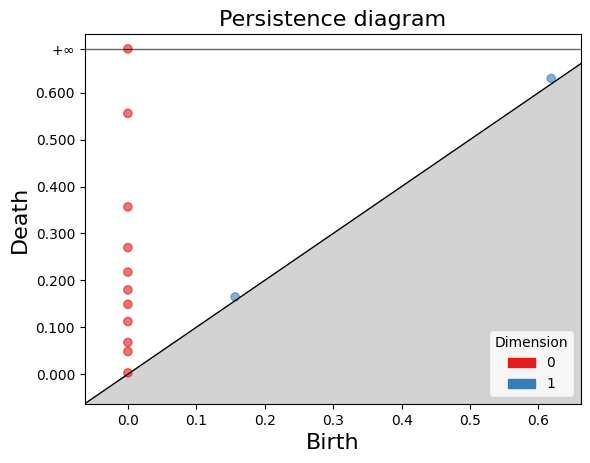

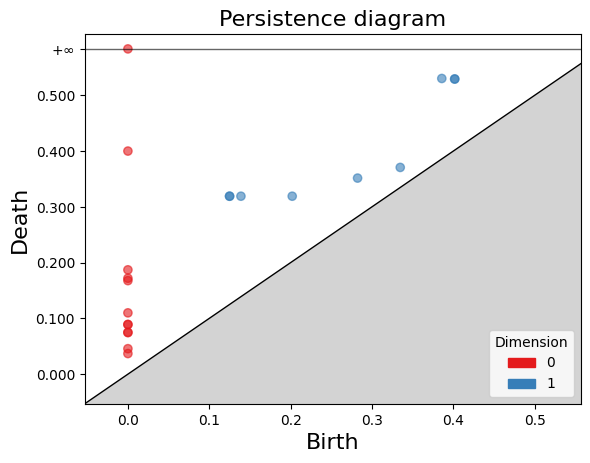

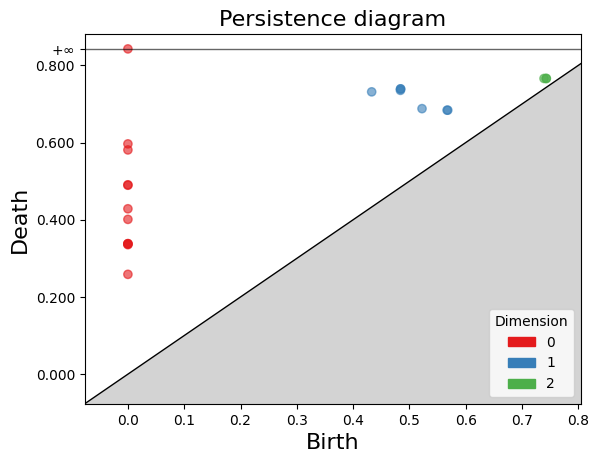

In [19]:
# HSIC correlation-based complex
print("General total time series data ")
constant_metrics_dict=cp.create_metric_matrix(results_df)
simplex_hsic, diag_hsic = cp.build_rips_complex(constant_metrics_dict["hsic_dist"])
simplex_cor, diag_cor = cp.build_rips_complex(constant_metrics_dict["pearson_dist"])
simplex_dcor, diag_dcor = cp.build_rips_complex(constant_metrics_dict["dcor_dist"])


<Axes: title={'center': 'Persistence barcode'}>

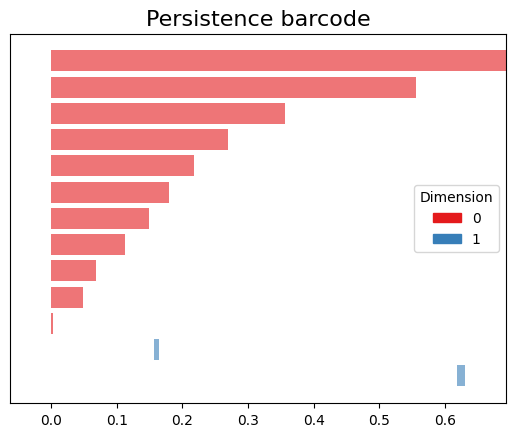

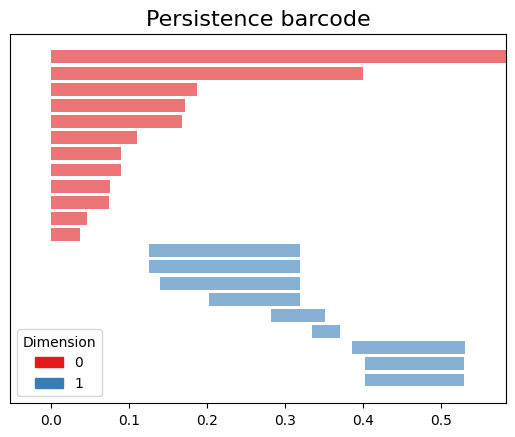

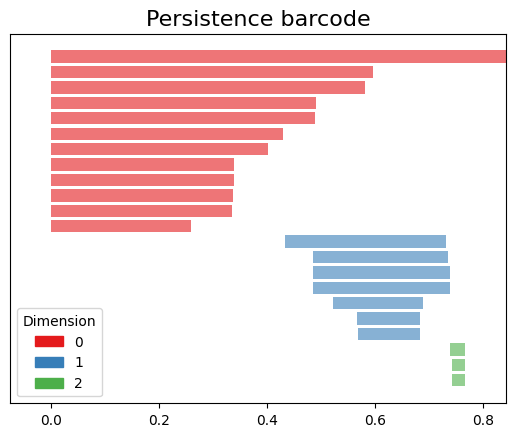

In [20]:
gd.plot_persistence_barcode(simplex_hsic.persistence())
gd.plot_persistence_barcode(simplex_cor.persistence())
gd.plot_persistence_barcode(simplex_dcor.persistence())

# Summary and interpretation for persistence feature in the table 
- Dimensions: 0 implies an individual vertex/signal, 1 is a persistent edge connecting two signals, 2 is a triangle connecting 3 vertices and so forth. 
- Persistence refers to individual permenence. Thus the greater the lifetime (death-birth) the greater the importance to the overall system. With this we can measure the complexity of the structure by its dimension and its relative importance by its lifetime
- Persistent features dont disappear totally but rather merge with other features driven by its distance metric. 
- When speaking of a feature death in reality we are speaking of what they merge into. 

In [21]:
rs.describe_persistence_features_table(simplex_dcor, df_cleaned.columns)

,Feature_ID,Dimension,Birth_Time,Death_Time,Lifetime,Birth_From,Death_From
0,21,0,0.000000,∞,∞,Node 'u',∞ (persists forever)
1,10,0,0.000000,∞,∞,Node 'v',Edge between 'v' and 'u'
2,11,0,0.000000,0.59663,0.59663,Edge between 'psi_y' and 'os_y',"Triangle formed by 'tau_wind_yaw', 'psi_y', 'c..."
3,12,0,0.000000,0.580963,0.580963,Edge between 'psi_y' and 'chi_desired_deg',"Triangle formed by 'tau_wind_yaw', 'v', 'psi_y'"
4,13,0,0.000000,0.490577,0.490577,Edge between 'v' and 'psi_y',"Triangle formed by 'tau_wind_yaw', 'tau_wind_s..."
5,14,0,0.000000,0.489554,0.489554,Edge between 'psi_y' and 'v_current',"Triangle formed by 'tau_wind_sway', 'v', 'v_cu..."
6,15,0,0.000000,0.428515,0.428515,Edge between 'tau_wind_surge' and 'psi_y',"Triangle formed by 'tau_wind_yaw', 'tau_wind_s..."
7,16,0,0.000000,0.401063,0.401063,Edge between 'psi_y' and 'psi_x',"Triangle formed by 'u', 'psi_y', 'psi_x'"
8,17,0,0.000000,0.338013,0.338013,Edge between 'psi_y' and 'u_current',"Triangle formed by 'u', 'psi_y', 'u_current'"
9,18,0,0.000000,0.338013,0.338013,"Triangle formed by 'tau_wind_sway', 'psi_x', '...","3D simplex with nodes 'tau_wind_sway', 'u', 'p..."


# Data visualization of the structure
- The next plots is shown for a very specific correlation metric and filtration threshold, play with different thresholds and correlation metrics to see how the simplicial complex changes.

/home/manret/SComplex/.venv/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/home/manret/SComplex/src/report_summary_sc.py:180: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  triangle = plt.Polygon(triangle_points, color="lightgreen", edgecolor="black", alpha=0.5)


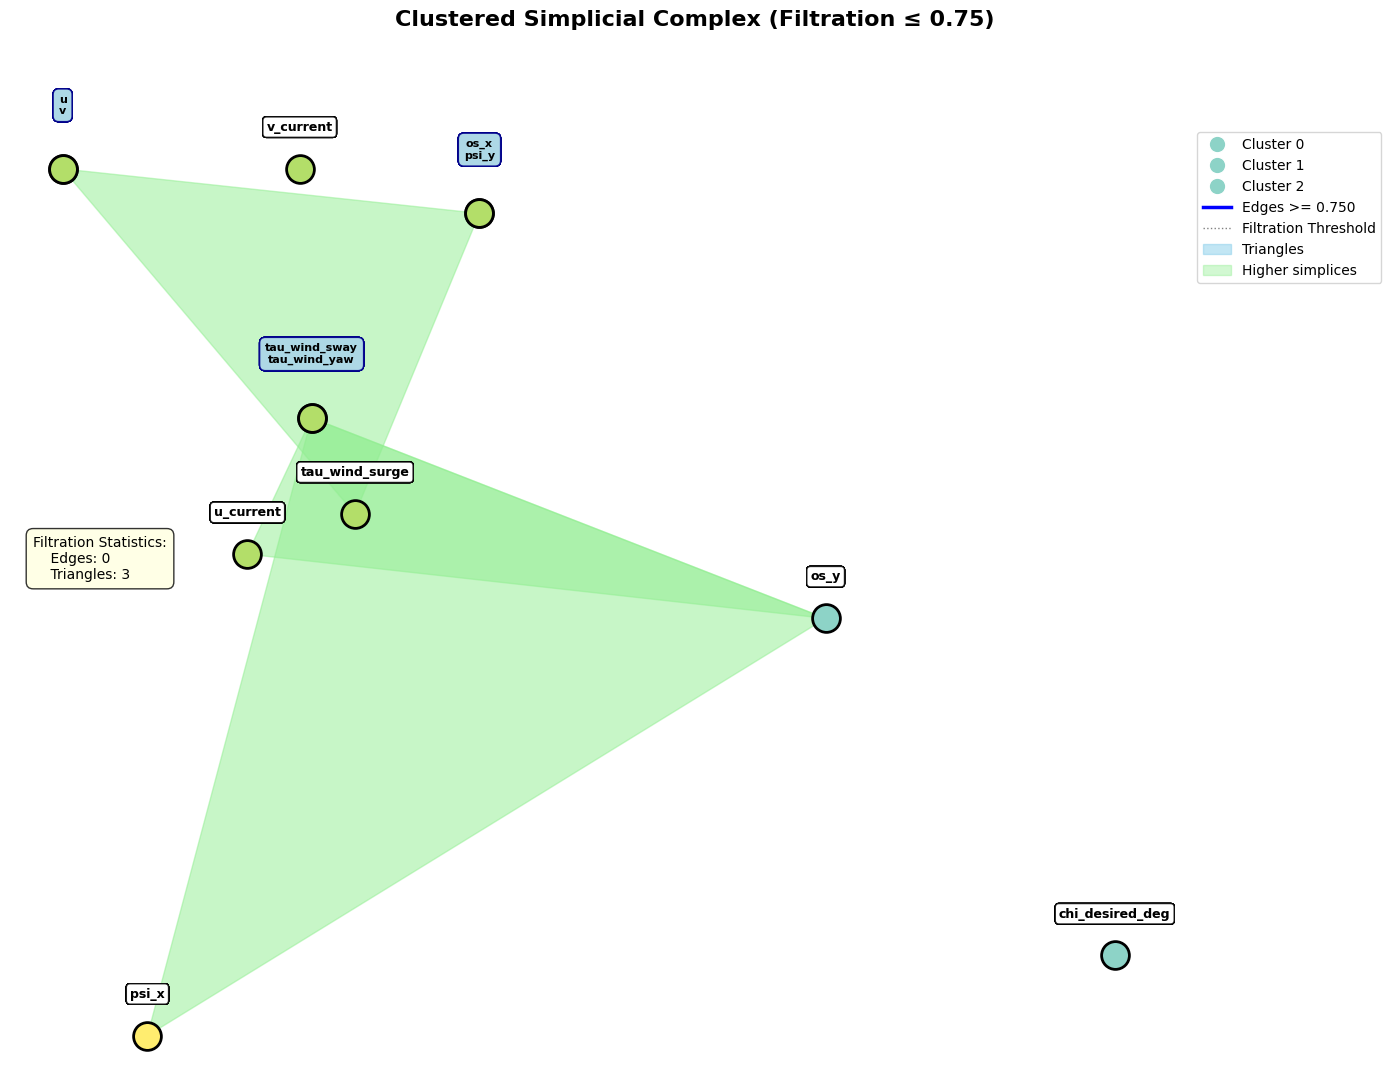

In [22]:
persistence_information=rs.create_persistence_information(simplex_dcor)
rs.visualize_clustered_simplicial_complex(simplex_dcor,persistence_information, df_cleaned.columns, constant_metrics_dict["dcor_dist"], filtration_threshold=0.75)